In [1]:
from paretoCardinalityInfluence import *

import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    })
else:
    mpl.rcParams.update({"text.usetex": False})

# Import influence datasets
data_path_HEPT = '../../datasets/raw_data/influence/NetHEPT/hep.txt'
data_path_PHY = '../../datasets/raw_data/influence/NetPHY/phy.txt'

G_HEPT = import_influence_data(data_path_HEPT)
G_PHY = import_influence_data(data_path_PHY)

2026-02-07 21:13:04,997 |INFO: Imported influence graph with 1673 nodes and 3863 edges
2026-02-07 21:13:06,550 |INFO: Imported influence graph with 912 nodes and 8748 edges


In [2]:
def findApproximateParetoSolutionsInfluence(G, k_max, num_samples=35, num_runs=10, dataset_name=""):
    '''
    Run algorithms over multiple runs and plot mean +/- std (Influence vs Cardinality).
    Parameters:
    - G: Graph
    - k_max: Maximum cardinality
    - num_samples: Number of Monte Carlo samples per run
    - num_runs: Number of independent runs
    - dataset_name: Name of the dataset for plotting
    '''
    algo_names = ["C-Greedy", "TopK", "Random"]

    # containers across runs
    all_influences = {alg: [] for alg in algo_names}
    all_runtimes = {alg: [] for alg in algo_names}

    for _ in range(num_runs):
        run_influences = {alg: [] for alg in algo_names}
        run_runtimes = {alg: [] for alg in algo_names}

        # C-Greedy (formerly ParetoGreedy-Cardinality)
        pareto = paretoCardinalityInfluence(G=G, k_max=k_max, num_samples=num_samples)
        _, _, runTime = pareto.paretoGreedy()
        influences = [pareto.kSolDict.get(k, {'Influence': 0})['Influence'] for k in range(1, k_max + 1)]
        run_influences['C-Greedy'] = influences
        run_runtimes['C-Greedy'] = runTime

        # Top K
        pareto2 = paretoCardinalityInfluence(G=G, k_max=k_max, num_samples=num_samples)
        _, _, runTime = pareto2.top_k()
        influences = [pareto2.kSolDict.get(k, {'Influence': 0})['Influence'] for k in range(1, k_max + 1)]
        run_influences['TopK'] = influences
        run_runtimes['TopK'] = runTime

        # Random
        pareto3 = paretoCardinalityInfluence(G=G, k_max=k_max, num_samples=num_samples)
        _, _, runTime = pareto3.random_selection()
        influences = [pareto3.kSolDict.get(k, {'Influence': 0})['Influence'] for k in range(1, k_max + 1)]
        run_influences['Random'] = influences
        run_runtimes['Random'] = runTime

        # store per-run arrays and total runtimes
        for alg in algo_names:
            arr = np.array(run_influences[alg], dtype=float)
            if arr.size == 0:
                arr = np.zeros(k_max, dtype=float)
            all_influences[alg].append(arr)
            all_runtimes[alg].append(run_runtimes[alg])

    # compute mean and std across runs for each algorithm
    mean_influences = {}
    std_influences = {}
    for alg in algo_names:
        stacked = np.vstack(all_influences[alg])  # shape (num_runs, k_max)
        mean_influences[alg] = np.mean(stacked, axis=0)
        std_influences[alg] = np.std(stacked, axis=0) * 1
        
    # Plot mean influence with shaded std band (match cardinality teams formatting)
    tab10_colors = plt.get_cmap("tab10").colors
    color_map = {
        "TopK": tab10_colors[4],
        "C-Greedy": tab10_colors[1],
        "Random": tab10_colors[7],
    }
    marker_map = {
        "TopK": "o",
        "C-Greedy": "^",
        "Random": "s",
    }
    linestyle_map = {
        "TopK": (0, (1, 1)),
        "C-Greedy": (0, (3, 2)),
        "Random": (0, (2, 2)),
    }
    fig, ax = plt.subplots(figsize=(9, 5.5))
    for i, alg in enumerate(algo_names):
        mean = mean_influences[alg]
        std = std_influences[alg]
        marker_size = 7
        line_style = linestyle_map.get(alg, (0, (1, 1)))
        color = color_map.get(alg, tab10_colors[i % len(tab10_colors)])
        marker = marker_map.get(alg, 'o')
        zorder = 3
        ax.plot(range(1, k_max + 1), mean,
                label=rf"\texttt{{{alg}}}",
                color=color,
                linestyle=line_style,
                marker=marker,
                markersize=marker_size,
                markevery=5,
                markeredgewidth=1.1,
                markeredgecolor='k',
                linewidth=1.8,
                zorder=zorder)
        ax.fill_between(range(1, k_max + 1),
                        np.clip(mean - std, 0, None),
                        mean + std,
                        color=color,
                        alpha=0.18,
                        zorder=2)
    
    ax.set_xlabel(r'Cardinality, $k$', fontsize=28)
    ax.set_ylabel(r'Expected influence, $f$', fontsize=28)
    ax.set_title("")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=24)
    
    # Legend handles (saved separately)
    handles, labels = ax.get_legend_handles_labels()
    
    # Save figure
    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "cardinality"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_cardinality.pdf"
    fig.savefig(out_path, bbox_inches="tight")
    
    # Save legend as separate PDF
    if handles:
        legend_out_path = plots_dir / "cardinality_legend.pdf"
        if not legend_out_path.exists():
            legend_fig = plt.figure(figsize=(8, 2))
            legend_fig.legend(handles, labels, loc='center', ncol=3, fontsize=22, frameon=True)
            legend_fig.savefig(legend_out_path, bbox_inches="tight")
            plt.close(legend_fig)
    
    plt.show()
    
    # Runtime summary (mean ± std)
    runtime_lines = ["Runtime summary (mean ± std, seconds):"]
    for alg in algo_names:
        mean_rt = float(np.mean(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        std_rt = float(np.std(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        runtime_lines.append(f"  - {alg}: {mean_rt:.3f} ± {std_rt:.3f}")
    logging.info("\n".join(runtime_lines))
    
    return None

### NetHEPT Experiments

2026-02-07 21:13:06,805 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:1673, k=200
2026-02-07 21:13:07,063 |INFO: Cardinality Greedy Solution for k_max:200, Influence:387.700, Runtime = 0.26 seconds
2026-02-07 21:13:07,228 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:1673, k=200
2026-02-07 21:13:07,322 |INFO: Top-k Solution for k_max:200, Influence:292.900, Runtime = 0.09 seconds
2026-02-07 21:13:07,491 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:1673, k=200
2026-02-07 21:13:07,523 |INFO: Random Selection Solution for k_max:200, Influence:202.900, Runtime = 0.03 seconds
2026-02-07 21:13:07,689 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:1673, k=200
2026-02-07 21:13:07,978 |INFO: Cardinality Greedy Solution for k_max:200, Influence:385.600, Runtime = 0.29 seconds
2026-02-07 21:13:08,197 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:1673, k=

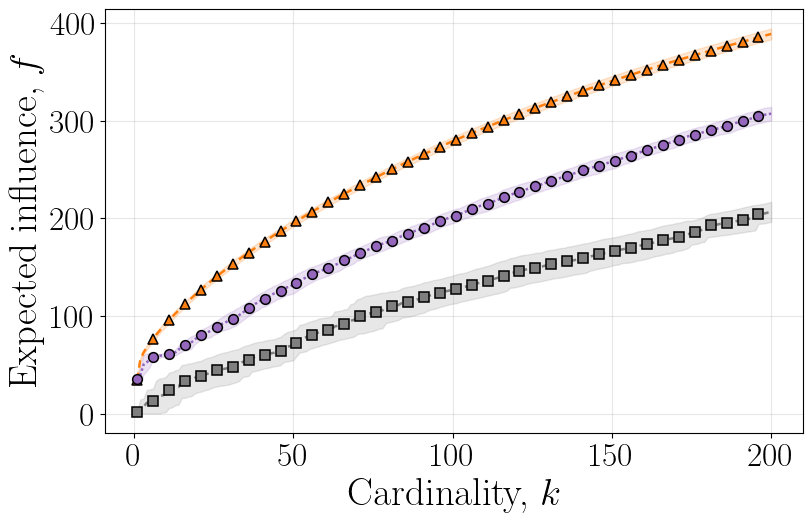

2026-02-07 21:13:17,011 |INFO: Runtime summary (mean ± std, seconds):
  - C-Greedy: 0.290 ± 0.079
  - TopK: 0.095 ± 0.009
  - Random: 0.033 ± 0.004


In [3]:
# Parameters
k_max = 200
num_samples = 10
num_runs = 10

findApproximateParetoSolutionsInfluence(G_HEPT, k_max, num_samples, num_runs, "NetHEPT")

### NetPHY Experiments

2026-02-07 21:13:17,463 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:912, k=200
2026-02-07 21:13:17,761 |INFO: Cardinality Greedy Solution for k_max:200, Influence:525.400, Runtime = 0.30 seconds
2026-02-07 21:13:18,115 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:912, k=200
2026-02-07 21:13:18,318 |INFO: Top-k Solution for k_max:200, Influence:498.000, Runtime = 0.20 seconds
2026-02-07 21:13:18,828 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:912, k=200
2026-02-07 21:13:18,933 |INFO: Random Selection Solution for k_max:200, Influence:442.700, Runtime = 0.10 seconds
2026-02-07 21:13:19,311 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:912, k=200
2026-02-07 21:13:19,698 |INFO: Cardinality Greedy Solution for k_max:200, Influence:530.400, Runtime = 0.38 seconds
2026-02-07 21:13:20,053 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:912, k=200
2

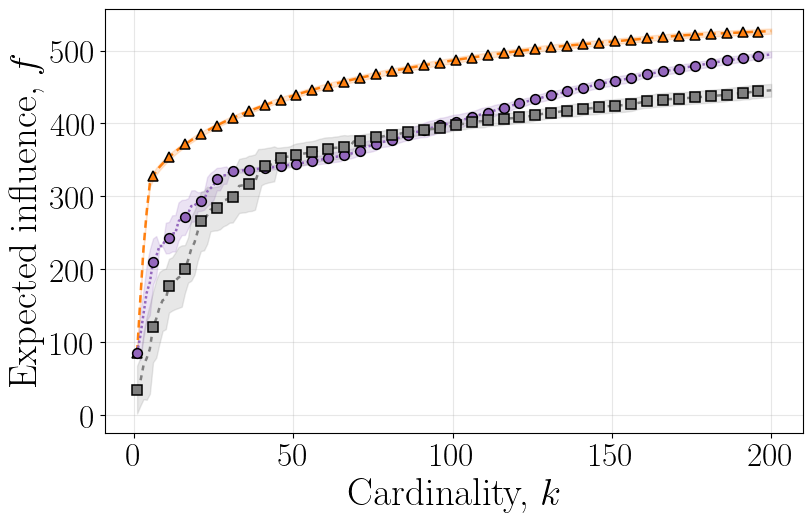

2026-02-07 21:13:35,648 |INFO: Runtime summary (mean ± std, seconds):
  - C-Greedy: 0.361 ± 0.077
  - TopK: 0.221 ± 0.046
  - Random: 0.107 ± 0.010


In [4]:
# Run for NetPHY
findApproximateParetoSolutionsInfluence(G_PHY, k_max, num_samples, num_runs, "NetPHY")